In [0]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('Breast_cancer_data.csv')
print(data.head())
data.info()

   mean_radius  mean_texture  ...  mean_smoothness  diagnosis
0        17.99         10.38  ...          0.11840          0
1        20.57         17.77  ...          0.08474          0
2        19.69         21.25  ...          0.10960          0
3        11.42         20.38  ...          0.14250          0
4        20.29         14.34  ...          0.10030          0

[5 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [3]:
data.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

So data is clean and therefore no need to remove null values

Next we split the dataset into train set and the test set.

In [0]:
X = data.iloc[:,0:data.shape[1]-1]
Y = data.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

Next we standardize the values of the dataset.

In [0]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

Finally we train a LogisticRegression model by our Train set to predit our test set

In [6]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train_std,Y_train)
Y_pred = classifier.predict(X_test_std)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test,Y_pred)
print(conf)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

[[57  6]
 [10 98]]
0.9064327485380117


Now let us try to improve our accuracy.
We will try to improve the accuracy by two ways


1.  changing the standard scale 
2.  Using feature selection to eliminate the least significant features 





Before using the feature selection let us look into the relations between the features by a pairplot


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


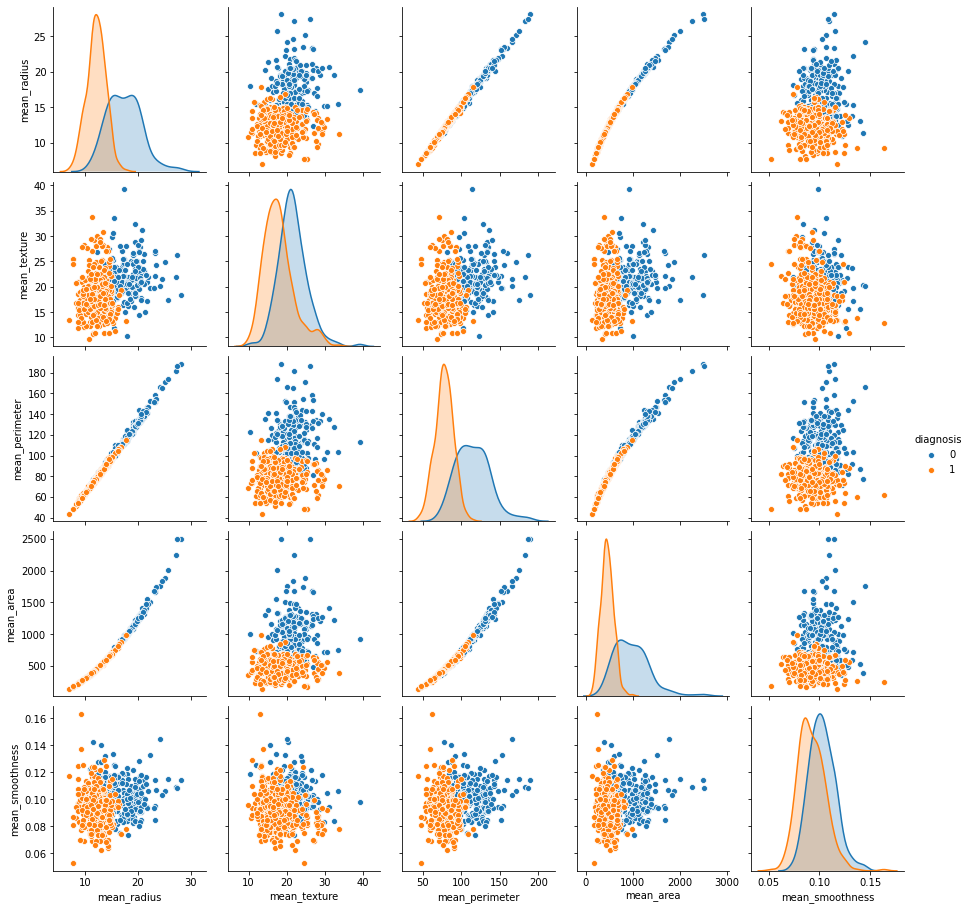

In [7]:
import seaborn as sns
sns.pairplot(data,hue='diagnosis')

From the above plot it is clear that 'mean_radius','mean_perimeter' and 'mean_area' are highly correlated.
So we can drop atleast one of them.
So next we check which of these 3 features is the most insignificant to the dependent variable and then we drop it.
To do so we apply feature selection to the dataset. 

Before applying feature selection to our main dataset let us scale our data set by min-max scaler

In [0]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.fit_transform(X_test)
X_minmax = scaler.fit_transform(X)

Now let us do feature selection by LassoCV 
It returns a list of absolute coefficient , the highest coefficient features are the most significant features.

In [9]:
from sklearn.linear_model import LassoCV
clf = LassoCV().fit(X_minmax, Y)
importance = np.abs(clf.coef_)
print(importance)

[0.         0.69956638 3.432296   1.85095834 0.82596121]


so let us remove the mean_radius feature and see if there is any increment in the accuracy


In [0]:
X = data.iloc[:,1:data.shape[1]-1]
Y = data.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
scaler = preprocessing.MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.fit_transform(X_test)

Next we train LogisticRegression classifier by our Train set and predict our test set to check if there is any increment in the accuracy




In [11]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train_minmax,Y_train)
Y_pred = classifier.predict(X_test_minmax)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test,Y_pred)
print(conf)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

[[ 55   8]
 [  3 105]]
0.935672514619883


So there is an increment in accuracy , lets see if it is not overfitted so next we do across-validation check.

In [12]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_minmax, y = Y_train, cv =10)
print(accuracies.mean())
print(accuracies.var())

0.9172435897435898
0.0016213387573964489


The mean accuracy score is quit high and the deviation is also quit low, so we can ensure that the model is not overfitted, so next lets see if we can increase the accuracy any further by other classification models.

Lets try our dataset with KNeighborsClassifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3,metric = 'minkowski', p=2)
classifier.fit(X_train_minmax,Y_train)
Y_pred = classifier.predict(X_test_minmax)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test,Y_pred)
print(conf)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

[[ 60   3]
 [  8 100]]
0.935672514619883


In [14]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_minmax, y = Y_train, cv =10)
print(accuracies.mean())
print(accuracies.var())

0.9171153846153846
0.002251072485207101


Lets try it with SVM

In [15]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state =0)
classifier.fit(X_train_minmax,Y_train)
Y_pred = classifier.predict(X_test_minmax)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test,Y_pred)
print(conf)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

[[ 58   5]
 [  5 103]]
0.9415204678362573


In [16]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_minmax, y = Y_train, cv =10)
print(accuracies.mean())
print(accuracies.var())

0.9321794871794872
0.0012550788954635102


Lets apply Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train_minmax,Y_train)
Y_pred = classifier.predict(X_test_minmax)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test,Y_pred)
print(conf)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

[[61  2]
 [15 93]]
0.9005847953216374


In [18]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_minmax, y = Y_train, cv =10)
print(accuracies.mean())
print(accuracies.var())

0.9071794871794872
0.0018770381328073638


Lastly lets train it with RandomForestClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 18,criterion = 'entropy',random_state = 0)
classifier.fit(X_train_minmax,Y_train)
Y_pred = classifier.predict(X_test_minmax)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test,Y_pred)
print(conf)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

[[60  3]
 [11 97]]
0.9181286549707602


In [20]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_minmax, y = Y_train, cv =10)
print(accuracies.mean())
print(accuracies.var())

0.9271153846153846
0.0013152572320841542


So from the above results we see that SVM gives the highest accuracy that is 0.9415204678362573 . The model is not overfitted as checked by the cross validation score.
so the best accuracy is 0.9415204678362573